In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [11]:
columns = inspector.get_columns('station')
for col in columns:
    print(col['name'], col['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
engine.execute('SELECT * FROM station').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Find the most recent date in the data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

last_date

'2017-08-23'

In [14]:
# Calculate the date one year from the last date in data set.
a_year = dt.date(2017,8,23) - dt.timedelta(days= 365)
a_year

datetime.date(2016, 8, 23)

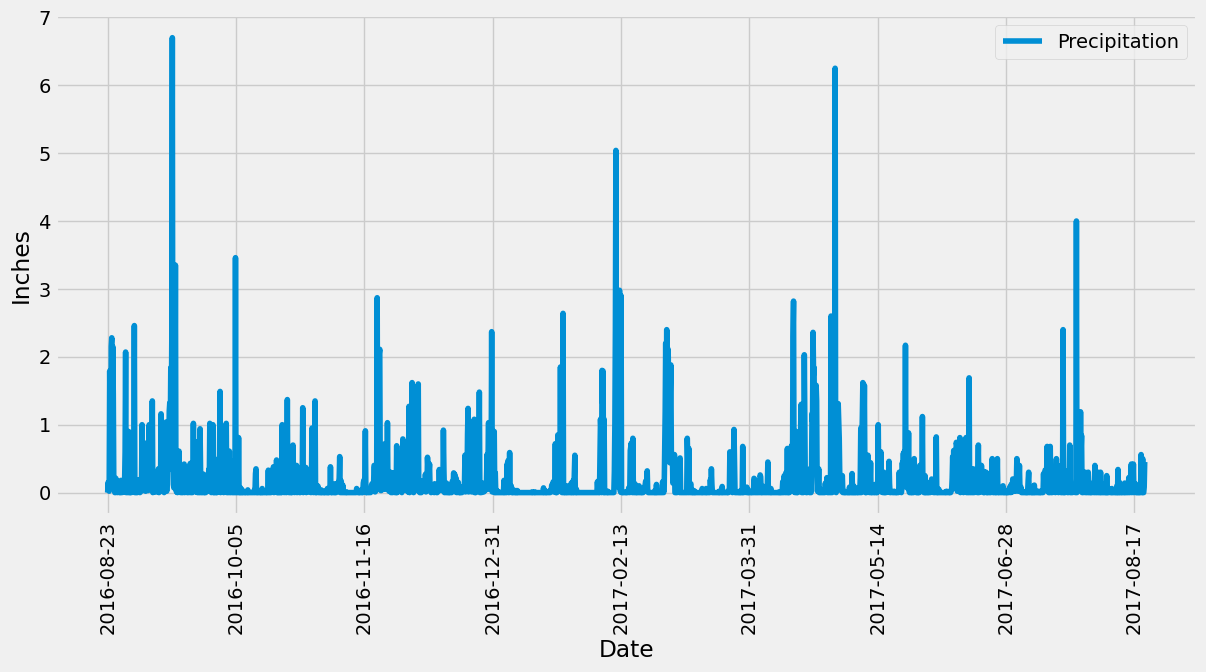

In [15]:
# Perform a query to retrieve the data and precipitation scores
precip = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= a_year, Measurement.prcp != None).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precip, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df.set_index('Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize=(12,6))
plt.tight_layout()
plt.ylabel('Inches')
plt.xticks(rotation=90)
plt.savefig('Images/Precipitation.png')

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.station)).all()

[(9,)]

In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
active_stations = session.query(Measurement.station,func.count(Measurement.station)).\
                               group_by(Measurement.station).\
                               order_by(func.count(Measurement.station).desc()).all()

# List the stations and their counts in descending order.
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
#Most active
most_active=session.query(Measurement.station,func.count(Measurement.station)).\
                               group_by(Measurement.station).\
                               order_by(func.count().desc()).first()
#Get the ID for most active
most_active_ID= most_active[0]

most_active_ID

'USC00519281'

In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp = session.query(func.min(Measurement.tobs),
                     func.max(Measurement.tobs),
                     func.avg(Measurement.tobs)).\
                filter(Measurement.station == most_active_ID).order_by(func.min(Measurement.tobs)).all()
temp

[(54.0, 85.0, 71.66378066378067)]

In [21]:
 # Calculate the date one year from the last date in the dataset using strptime.
a_year_ago = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)
#Most active
most_active=session.query(Measurement.station,func.count(Measurement.station)).\
                               group_by(Measurement.station).\
                               order_by(func.count().desc()).first()
#Get the ID for most active
most_active_ID= most_active[0]
    
# Query the last 12 months of temperature observation data of the most active station
temp_year = session.query(Measurement.date, Measurement.tobs).\
        filter(Measurement.date >= a_year_ago, Measurement.station == most_active_ID).\
        order_by(Measurement.date).all()
    
temp_year


[('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-30', 78.0),
 ('2016-10-01', 77.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-05', 79.0),
 ('2016-10-

In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station
temp_year = session.query(Measurement.tobs).\
      filter(Measurement.date >= a_year_ago, Measurement.station == most_active_ID).\
      order_by(Measurement.tobs).all()
temp_year

[(59.0,),
 (59.0,),
 (59.0,),
 (60.0,),
 (60.0,),
 (61.0,),
 (62.0,),
 (62.0,),
 (62.0,),
 (62.0,),
 (62.0,),
 (62.0,),
 (63.0,),
 (63.0,),
 (63.0,),
 (63.0,),
 (64.0,),
 (64.0,),
 (64.0,),
 (65.0,),
 (65.0,),
 (65.0,),
 (65.0,),
 (65.0,),
 (65.0,),
 (65.0,),
 (66.0,),
 (66.0,),
 (66.0,),
 (66.0,),
 (66.0,),
 (67.0,),
 (67.0,),
 (67.0,),
 (67.0,),
 (67.0,),
 (67.0,),
 (67.0,),
 (67.0,),
 (67.0,),
 (67.0,),
 (67.0,),
 (67.0,),
 (67.0,),
 (67.0,),
 (67.0,),
 (68.0,),
 (68.0,),
 (68.0,),
 (68.0,),
 (68.0,),
 (68.0,),
 (68.0,),
 (68.0,),
 (68.0,),
 (68.0,),
 (68.0,),
 (68.0,),
 (69.0,),
 (69.0,),
 (69.0,),
 (69.0,),
 (69.0,),
 (69.0,),
 (69.0,),
 (69.0,),
 (69.0,),
 (69.0,),
 (69.0,),
 (69.0,),
 (69.0,),
 (69.0,),
 (69.0,),
 (69.0,),
 (69.0,),
 (69.0,),
 (69.0,),
 (70.0,),
 (70.0,),
 (70.0,),
 (70.0,),
 (70.0,),
 (70.0,),
 (70.0,),
 (70.0,),
 (70.0,),
 (70.0,),
 (70.0,),
 (70.0,),
 (70.0,),
 (70.0,),
 (70.0,),
 (70.0,),
 (70.0,),
 (70.0,),
 (70.0,),
 (70.0,),
 (70.0,),
 (70.0,),
 (71.0,),


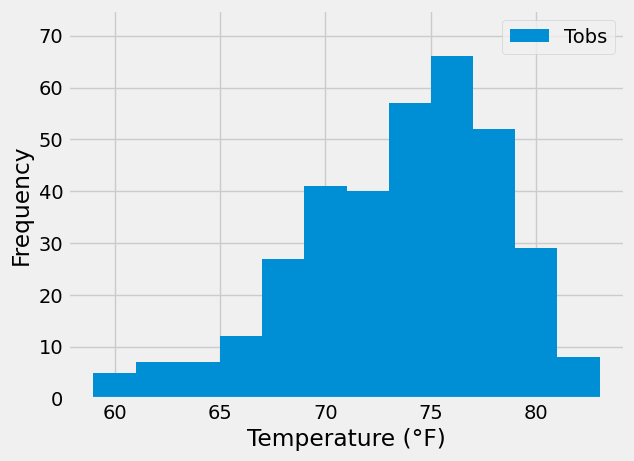

In [23]:
 # plot the results as a histogram
df2 = pd.DataFrame(temp_year, columns=['Tobs'])
df2['Tobs'].plot.hist(bins=12)
plt.ylim(0,75)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('Images/station-histogram.png')

# Close Session

In [24]:
# Close Session
session.close()